# Sesión 03: Exploración y Visualización de Datos de Producción Petrolera
# Laboratorio Práctico

Este notebook es parte del programa de Machine Learning Aplicado para la industria petrolera.
En esta sesión aprenderemos a:
1. Realizar análisis exploratorio de datos (EDA) en datasets de producción petrolera
2. Aplicar técnicas estadísticas descriptivas para entender nuestros datos
3. Crear visualizaciones efectivas para comunicar patrones y tendencias
4. Identificar insights que pueden generar valor operativo

In [1]:
# Importamos las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Para visualizaciones interactivas
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configuramos opciones de visualización
plt.style.use('seaborn-v0_8-whitegrid')  # Estilo visual limpio
sns.set_palette("deep")  # Paleta de colores contrastante
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas

print("¡Entorno configurado correctamente!")

¡Entorno configurado correctamente!


## 1. Carga y Exploración Inicial de Datos

Comenzaremos cargando un conjunto de datos de producción petrolera. Este 
dataset contiene información diaria sobre varios pozos, incluyendo:
- Tasas de producción (petróleo, gas, agua)
- Presiones (cabezal, línea)
- Parámetros operativos (horas operativas, choke)
- Información contextual (fecha, pozo, campo)

In [3]:
# Cargamos los datos
# En un entorno real, podríamos hacer:
# df = pd.read_csv("data/produccion_petrolera.csv")

# Para este ejercicio utilizaremos datos sintéticos
# que recrean patrones típicos de la industria

# Generamos datos sintéticos para el laboratorio
np.random.seed(42)  # Para reproducibilidad

# Período de tiempo: 365 días
fechas = pd.date_range(start='2022-01-01', periods=365, freq='D')

# Creamos 5 pozos con características diferentes
pozos = ['POZO-A', 'POZO-B', 'POZO-C', 'POZO-D', 'POZO-E']

# Lista para almacenar los datos
datos = []

In [4]:
# Función para crear un patrón de producción realista con tendencia de declinación
def generar_produccion(dias, tasa_inicial, declive_anual=0.2, ruido=0.1, intervencion=None):
    # Tendencia de declive exponencial (común en pozos petroleros)
    declive_diario = (1 - declive_anual) ** (1/365)
    tendencia = tasa_inicial * declive_diario ** np.arange(dias)
    
    # Agregamos ruido para simular variaciones naturales
    ruido = np.random.normal(0, ruido * tasa_inicial, dias)
    produccion = tendencia + ruido
    
    # Opcional: simulamos una intervención (workover) que mejora la producción
    if intervencion:
        dia_intervencion, mejora = intervencion
        if dia_intervencion < dias:
            produccion[dia_intervencion:] = produccion[dia_intervencion:] * mejora
    
    return np.maximum(0, produccion)  # No puede haber producción negativa

In [5]:
# Generamos datos para cada pozo
for pozo in pozos:
    # Cada pozo tiene características distintas
    if pozo == 'POZO-A':
        # Pozo con alta producción inicial y rápida declinación
        prod_petroleo = generar_produccion(365, 1200, declive_anual=0.4, intervencion=(180, 1.5))
        prod_gas = prod_petroleo * 1.2 + np.random.normal(0, 50, 365)
        prod_agua = generar_produccion(365, 200, declive_anual=-0.5)  # Incremento de agua
        
    elif pozo == 'POZO-B':
        # Pozo estable con baja declinación
        prod_petroleo = generar_produccion(365, 800, declive_anual=0.15)
        prod_gas = prod_petroleo * 0.8 + np.random.normal(0, 30, 365)
        prod_agua = generar_produccion(365, 300, declive_anual=0.1)
        
    elif pozo == 'POZO-C':
        # Pozo con problemas operativos (caídas súbitas)
        prod_petroleo = generar_produccion(365, 950, declive_anual=0.25)
        # Simulamos problemas en ciertos días
        for problema in [50, 120, 200, 280]:
            ventana = np.random.randint(3, 10)  # Duración del problema
            prod_petroleo[problema:problema+ventana] *= 0.3
        prod_gas = prod_petroleo * 1.5 + np.random.normal(0, 40, 365)
        prod_agua = generar_produccion(365, 250, declive_anual=0.05)
        
    elif pozo == 'POZO-D':
        # Pozo nuevo con alta producción
        prod_petroleo = generar_produccion(365, 1500, declive_anual=0.3)
        prod_gas = prod_petroleo * 1.1 + np.random.normal(0, 60, 365)
        prod_agua = generar_produccion(365, 100, declive_anual=-0.3)
        
    else:  # POZO-E
        # Pozo maduro con oscilaciones
        prod_petroleo = generar_produccion(365, 500, declive_anual=0.1, ruido=0.2)
        prod_gas = prod_petroleo * 0.7 + np.random.normal(0, 20, 365)
        prod_agua = generar_produccion(365, 700, declive_anual=-0.1)
    
    # Parámetros operativos
    presion_cabezal = np.random.normal(1800, 100, 365) - np.arange(365) * 0.2
    presion_linea = np.random.normal(800, 50, 365)
    temperatura = np.random.normal(80, 5, 365) + np.sin(np.arange(365) * 2 * np.pi / 365) * 3
    choke = 50 + np.random.normal(0, 5, 365)
    horas_operativas = np.random.normal(23, 1, 365)
    
    # Ajustamos valores a rangos realistas
    choke = np.clip(choke, 0, 100)
    horas_operativas = np.clip(horas_operativas, 0, 24)
    
    # Creamos registros diarios para este pozo
    for i, fecha in enumerate(fechas):
        registro = {
            'fecha': fecha,
            'pozo': pozo,
            'campo': 'CAMPO-' + pozo[-1],  # Agrupamos por el último carácter del nombre
            'petroleo_bbl': max(0, prod_petroleo[i]),
            'gas_mscf': max(0, prod_gas[i]),
            'agua_bbl': max(0, prod_agua[i]),
            'presion_cabezal_psi': max(0, presion_cabezal[i]),
            'presion_linea_psi': max(0, presion_linea[i]),
            'temperatura_c': temperatura[i],
            'choke_percent': choke[i],
            'horas_operativas': horas_operativas[i]
        }
        
        datos.append(registro)

In [6]:
# Creamos el DataFrame con todos los datos
df = pd.DataFrame(datos)

# Calculamos campos derivados útiles para el análisis
df['liquido_total'] = df['petroleo_bbl'] + df['agua_bbl']
df['corte_agua'] = df['agua_bbl'] / df['liquido_total']
df['gas_petroleo_ratio'] = df['gas_mscf'] / df['petroleo_bbl']
df['produccion_equivalente'] = df['petroleo_bbl'] + df['gas_mscf'] / 6  # Conversión aproximada

# Mostramos las primeras filas para verificar
print("Vista previa de los datos generados:")
df.head()

Vista previa de los datos generados:


,fecha,pozo,campo,petroleo_bbl,gas_mscf,agua_bbl,presion_cabezal_psi,presion_linea_psi,temperatura_c,choke_percent,horas_operativas,liquido_total,corte_agua,gas_petroleo_ratio,produccion_equivalente
0,2022-01-01,POZO-A,CAMPO-A,1259.605698,1491.465814,203.916905,1791.928342,793.077201,82.209703,42.009378,23.534629,1463.522603,0.139333,1.184074,1508.183334
1,2022-01-02,POZO-A,CAMPO-A,1181.730032,1429.280662,180.654841,1807.663519,738.785088,74.599645,52.310863,20.364252,1362.384872,0.132602,1.209482,1419.943476
2,2022-01-03,POZO-A,CAMPO-A,1274.368468,1529.871781,208.609894,1599.779932,789.548837,87.157927,60.121548,23.003376,1482.978362,0.140670,1.200494,1529.347098
3,2022-01-04,POZO-A,CAMPO-A,1377.735865,1658.166842,166.615958,1891.032767,757.473977,79.661918,43.184130,23.327821,1544.351822,0.107887,1.203545,1654.097005
4,2022-01-05,POZO-A,CAMPO-A,1165.202656,1359.592698,221.473781,1833.848848,770.973828,80.300655,50.948531,23.924270,1386.676437,0.159716,1.166829,1391.801439


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   fecha                   1825 non-null   datetime64[ns]
 1   pozo                    1825 non-null   object        
 2   campo                   1825 non-null   object        
 3   petroleo_bbl            1825 non-null   float64       
 4   gas_mscf                1825 non-null   float64       
 5   agua_bbl                1825 non-null   float64       
 6   presion_cabezal_psi     1825 non-null   float64       
 7   presion_linea_psi       1825 non-null   float64       
 8   temperatura_c           1825 non-null   float64       
 9   choke_percent           1825 non-null   float64       
 10  horas_operativas        1825 non-null   float64       
 11  liquido_total           1825 non-null   float64       
 12  corte_agua              1825 non-null   float64 

In [8]:
df.describe()

,fecha,petroleo_bbl,gas_mscf,agua_bbl,presion_cabezal_psi,presion_linea_psi,temperatura_c,choke_percent,horas_operativas,liquido_total,corte_agua,gas_petroleo_ratio,produccion_equivalente
count,1825,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000
mean,2022-07-02 00:00:00.000000256,881.963064,973.320973,324.572474,1764.023397,800.388854,80.046137,49.975162,22.921134,1206.535537,0.280329,1.059526,1044.183226
min,2022-01-01 00:00:00,163.006778,85.524819,77.391472,1433.975106,615.581735,62.508454,30.816722,19.670496,426.918789,0.053414,0.451341,185.919978
25%,2022-04-02 00:00:00,650.718321,522.405512,209.447511,1692.015523,766.948906,76.299515,46.676495,22.355660,1049.784154,0.159975,0.777208,746.326372
50%,2022-07-02 00:00:00,842.387910,1114.371215,256.637242,1764.749148,800.734705,79.957900,49.793537,23.003376,1188.151367,0.230937,1.097622,1010.776832
75%,2022-10-01 00:00:00,1138.152105,1365.085252,309.894627,1835.512145,834.716319,83.764559,53.411694,23.644311,1350.210139,0.307943,1.226407,1358.205588
max,2022-12-31 00:00:00,2037.002906,2485.873766,986.139004,2075.065444,971.445524,97.980409,66.886915,24.000000,2277.988269,0.797238,1.755897,2451.315200
std,NaN,327.456762,473.391522,216.901299,104.288919,49.695904,5.447616,5.042566,0.860390,229.074862,0.184610,0.289902,400.842917


In [40]:
df.to_hdf("ejercicio.hdf",key="datos1")

In [41]:
pd.read_hdf("ejercicio.hdf")

,fecha,pozo,campo,petroleo_bbl,gas_mscf,agua_bbl,presion_cabezal_psi,presion_linea_psi,temperatura_c,choke_percent,horas_operativas,liquido_total,corte_agua,gas_petroleo_ratio,produccion_equivalente,mes
0,2022-01-01,POZO-A,CAMPO-A,1259.605698,1491.465814,203.916905,1791.928342,793.077201,82.209703,42.009378,23.534629,1463.522603,0.139333,1.184074,1508.183334,2022-01
1,2022-01-02,POZO-A,CAMPO-A,1181.730032,1429.280662,180.654841,1807.663519,738.785088,74.599645,52.310863,20.364252,1362.384872,0.132602,1.209482,1419.943476,2022-01
2,2022-01-03,POZO-A,CAMPO-A,1274.368468,1529.871781,208.609894,1599.779932,789.548837,87.157927,60.121548,23.003376,1482.978362,0.140670,1.200494,1529.347098,2022-01
3,2022-01-04,POZO-A,CAMPO-A,1377.735865,1658.166842,166.615958,1891.032767,757.473977,79.661918,43.184130,23.327821,1544.351822,0.107887,1.203545,1654.097005,2022-01
4,2022-01-05,POZO-A,CAMPO-A,1165.202656,1359.592698,221.473781,1833.848848,770.973828,80.300655,50.948531,23.924270,1386.676437,0.159716,1.166829,1391.801439,2022-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1820,2022-12-27,POZO-E,CAMPO-E,440.849855,291.937633,818.083224,1642.742741,838.353134,81.196673,43.749872,23.862391,1258.933079,0.649823,0.662216,489.506127,2022-12
1821,2022-12-28,POZO-E,CAMPO-E,531.506085,355.327489,819.811081,1788.790912,826.899184,83.126305,51.528506,21.382379,1351.317166,0.606676,0.668529,590.727333,2022-12
1822,2022-12-29,POZO-E,CAMPO-E,617.516104,394.932310,758.630426,1713.151216,835.892311,83.213985,52.757183,23.449713,1376.146530,0.551272,0.639550,683.338156,2022-12
1823,2022-12-30,POZO-E,CAMPO-E,475.409235,364.584376,791.915867,1730.756765,867.549695,75.258164,53.629106,24.000000,1267.325102,0.624872,0.766885,536.173298,2022-12


## 2. Estadísticas Descriptivas para Datos de Producción

Las estadísticas descriptivas son fundamentales para entender nuestros datos:
- Medidas de tendencia central (media, mediana)
- Medidas de dispersión (desviación estándar, rango)
- Percentiles y distribuciones
- Correlaciones entre variables

Estas métricas nos dan una primera visión sobre el comportamiento de los pozos.

In [ ]:
# Estadísticas descriptivas generales
print("Estadísticas descriptivas de todo el dataset:")
descripcion = df.describe().T
descripcion['cv'] = descripcion['std'] / descripcion['mean']  # Coeficiente de variación
descripcion 

Estadísticas descriptivas de todo el dataset:


,count,mean,min,25%,50%,75%,max,std,cv
fecha,1825,2022-07-02 00:00:00.000000256,2022-01-01 00:00:00,2022-04-02 00:00:00,2022-07-02 00:00:00,2022-10-01 00:00:00,2022-12-31 00:00:00,NaN,NaN
petroleo_bbl,1825.0,881.963064,163.006778,650.718321,842.38791,1138.152105,2037.002906,327.456762,0.371282
gas_mscf,1825.0,973.320973,85.524819,522.405512,1114.371215,1365.085252,2485.873766,473.391522,0.486367
agua_bbl,1825.0,324.572474,77.391472,209.447511,256.637242,309.894627,986.139004,216.901299,0.668268
presion_cabezal_psi,1825.0,1764.023397,1433.975106,1692.015523,1764.749148,1835.512145,2075.065444,104.288919,0.05912
presion_linea_psi,1825.0,800.388854,615.581735,766.948906,800.734705,834.716319,971.445524,49.695904,0.06209
temperatura_c,1825.0,80.046137,62.508454,76.299515,79.9579,83.764559,97.980409,5.447616,0.068056
choke_percent,1825.0,49.975162,30.816722,46.676495,49.793537,53.411694,66.886915,5.042566,0.100901
horas_operativas,1825.0,22.921134,19.670496,22.35566,23.003376,23.644311,24.0,0.86039,0.037537
liquido_total,1825.0,1206.535537,426.918789,1049.784154,1188.151367,1350.210139,2277.988269,229.074862,0.189862


In [10]:
# Analizamos por pozo
print("\nPetróleo promedio por pozo (bbl/día):")
df.groupby('pozo')['petroleo_bbl'].mean().sort_values(ascending=False)


Petróleo promedio por pozo (bbl/día):


pozo
POZO-D    1265.003922
POZO-A    1151.168944
POZO-C     785.860574
POZO-B     735.624290
POZO-E     472.157589
Name: petroleo_bbl, dtype: float64

In [11]:
print("\nProducción total acumulada por pozo:")
produccion_acumulada = df.groupby('pozo').agg({
    'petroleo_bbl': 'sum',
    'gas_mscf': 'sum',
    'agua_bbl': 'sum'
})
produccion_acumulada


Producción total acumulada por pozo:


,petroleo_bbl,gas_mscf,agua_bbl
pozo,,,
POZO-A,420176.664551,503518.239777,90896.719232
POZO-B,268502.865811,215141.969225,103307.740282
POZO-C,286839.109376,429721.050000,88256.341746
POZO-D,461726.431372,506954.576436,41599.623478
POZO-E,172337.519940,120974.939579,268284.339952


In [14]:
# Análisis de tendencia mensual (promediando por mes)
df['mes'] = df['fecha'].dt.strftime('%Y-%m')
tendencia_mensual = df.groupby(['pozo', 'mes']).agg({
    'petroleo_bbl': 'mean',
    'gas_mscf': 'mean',
    'agua_bbl': 'mean'
}).reset_index()

print("\nTendencia mensual de producción (primeros 5 meses):")
tendencia_mensual.head()


Tendencia mensual de producción (primeros 5 meses):


,pozo,mes,petroleo_bbl,gas_mscf,agua_bbl
0,POZO-A,2022-01,1150.984739,1388.641354,200.957454
1,POZO-A,2022-02,1110.436984,1340.714837,216.588936
2,POZO-A,2022-03,1087.298649,1294.469148,217.744792
3,POZO-A,2022-04,1034.375820,1238.373886,227.160290
4,POZO-A,2022-05,983.427964,1174.562323,236.462608


In [15]:
# Análisis de correlación entre variables
print("\nMatriz de correlación entre variables principales:")
columnas_correlacion = ['petroleo_bbl', 'gas_mscf', 'agua_bbl', 
                        'presion_cabezal_psi', 'presion_linea_psi', 
                        'temperatura_c', 'choke_percent', 'horas_operativas']
matriz_correlacion = df[columnas_correlacion].corr()
matriz_correlacion


Matriz de correlación entre variables principales:


,petroleo_bbl,gas_mscf,agua_bbl,presion_cabezal_psi,presion_linea_psi,temperatura_c,choke_percent,horas_operativas
petroleo_bbl,1.000000,0.913887,-0.716633,0.040607,-0.012117,-0.020393,-0.008711,0.008906
gas_mscf,0.913887,1.000000,-0.743470,0.045634,-0.015975,-0.012329,-0.002308,0.020356
agua_bbl,-0.716633,-0.743470,1.000000,-0.006171,0.017587,0.019204,0.006912,-0.011445
presion_cabezal_psi,0.040607,0.045634,-0.006171,1.000000,0.005337,0.071490,0.054524,-0.013898
presion_linea_psi,-0.012117,-0.015975,0.017587,0.005337,1.000000,0.019428,-0.013194,-0.046849
temperatura_c,-0.020393,-0.012329,0.019204,0.071490,0.019428,1.000000,0.019769,0.001617
choke_percent,-0.008711,-0.002308,0.006912,0.054524,-0.013194,0.019769,1.000000,-0.051943
horas_operativas,0.008906,0.020356,-0.011445,-0.013898,-0.046849,0.001617,-0.051943,1.000000


## 3. Visualización de Series Temporales de Producción

Las series temporales son fundamentales en datos de producción petrolera.
Visualizarlas adecuadamente nos permite:
- Identificar tendencias de declive natural
- Detectar eventos operativos (cierres, intervenciones)
- Analizar patrones estacionales o cíclicos
- Comparar rendimiento entre pozos

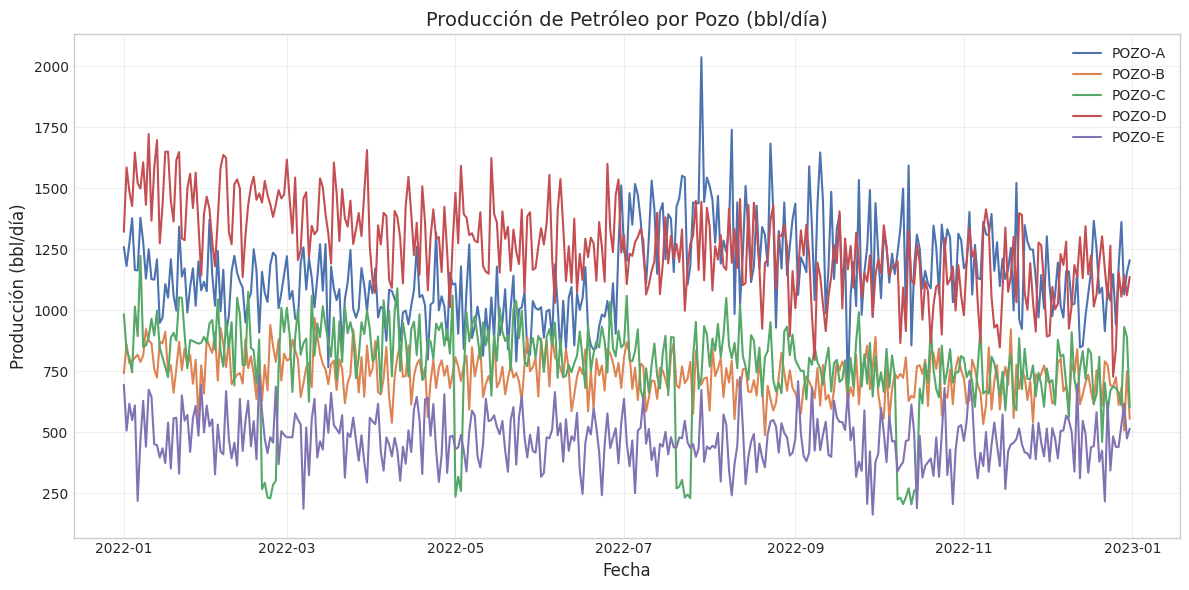

In [16]:
# Gráfico de series temporales de producción de petróleo por pozo
plt.figure(figsize=(12, 6))
for pozo in pozos:
    datos_pozo = df[df['pozo'] == pozo]
    plt.plot(datos_pozo['fecha'], datos_pozo['petroleo_bbl'], label=pozo)

plt.title('Producción de Petróleo por Pozo (bbl/día)', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Producción (bbl/día)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

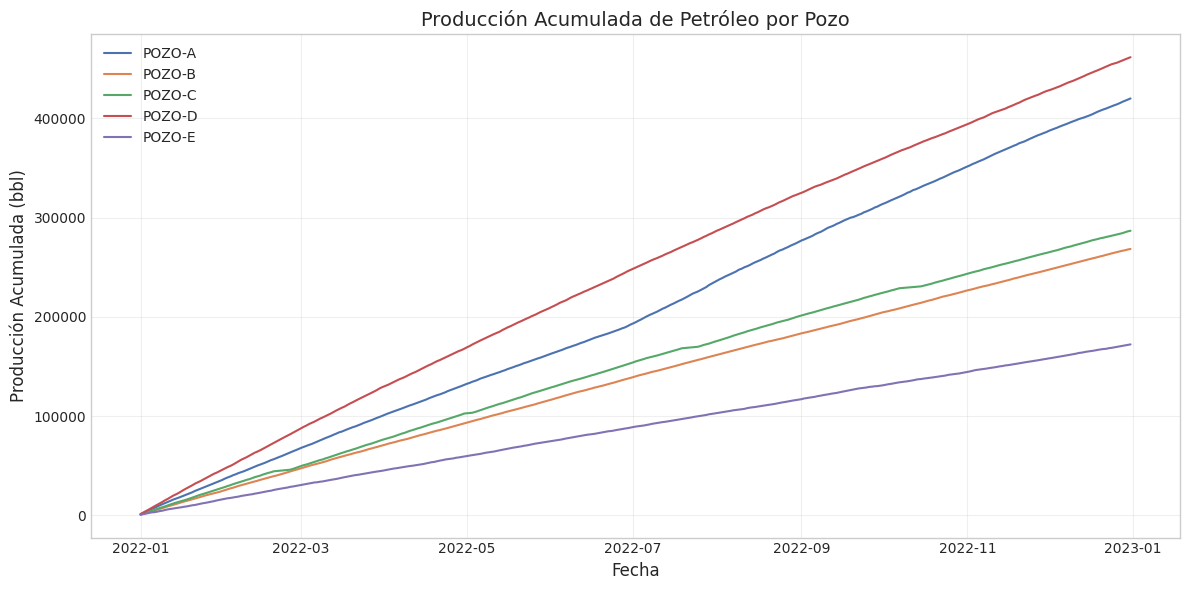

In [17]:
# Gráfico de producción acumulada
plt.figure(figsize=(12, 6))
for pozo in pozos:
    datos_pozo = df[df['pozo'] == pozo]
    plt.plot(datos_pozo['fecha'], datos_pozo['petroleo_bbl'].cumsum(), label=pozo)

plt.title('Producción Acumulada de Petróleo por Pozo', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Producción Acumulada (bbl)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

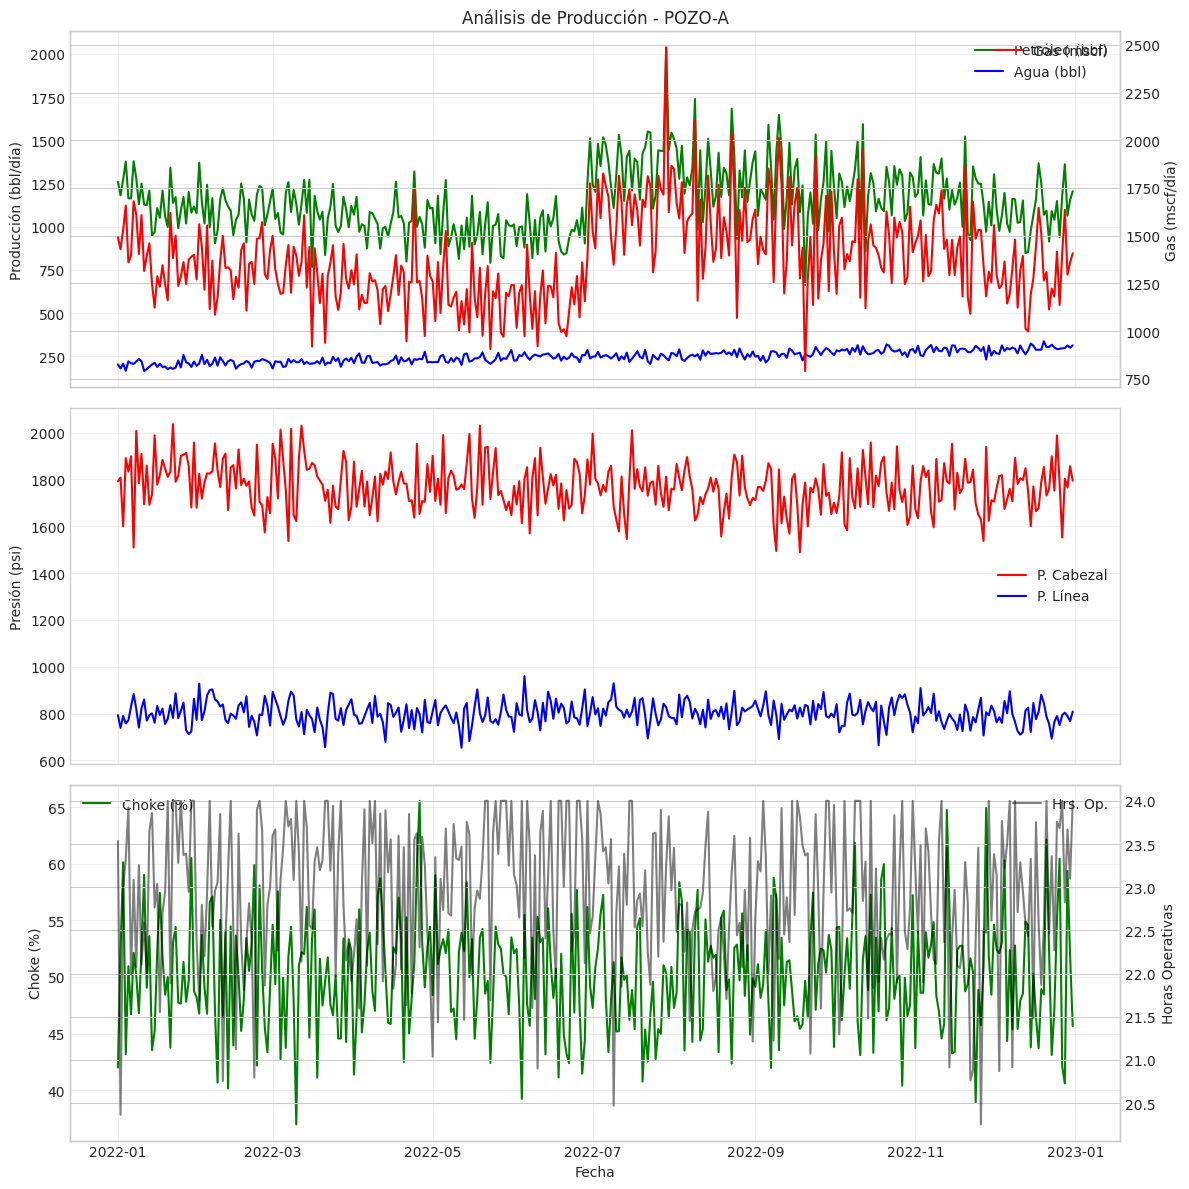

In [18]:
# Visualización de múltiples parámetros para un solo pozo
pozo_analisis = 'POZO-A'
datos_pozo = df[df['pozo'] == pozo_analisis]

# Creamos una figura con subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Producción (petróleo, gas, agua)
axes[0].plot(datos_pozo['fecha'], datos_pozo['petroleo_bbl'], 'g-', label='Petróleo (bbl)')
axes[0].plot(datos_pozo['fecha'], datos_pozo['agua_bbl'], 'b-', label='Agua (bbl)')
axes[0].set_ylabel('Producción (bbl/día)')
axes[0].set_title(f'Análisis de Producción - {pozo_analisis}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Línea secundaria para el gas (escala diferente)
ax_gas = axes[0].twinx()
ax_gas.plot(datos_pozo['fecha'], datos_pozo['gas_mscf'], 'r-', label='Gas (mscf)')
ax_gas.set_ylabel('Gas (mscf/día)')
ax_gas.legend(loc='upper right')

# Presiones
axes[1].plot(datos_pozo['fecha'], datos_pozo['presion_cabezal_psi'], 'r-', label='P. Cabezal')
axes[1].plot(datos_pozo['fecha'], datos_pozo['presion_linea_psi'], 'b-', label='P. Línea')
axes[1].set_ylabel('Presión (psi)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Parámetros operativos
axes[2].plot(datos_pozo['fecha'], datos_pozo['choke_percent'], 'g-', label='Choke (%)')
axes[2].set_ylabel('Choke (%)')
axes[2].set_xlabel('Fecha')
axes[2].legend(loc='upper left')
axes[2].grid(True, alpha=0.3)

# Línea secundaria para horas operativas
ax_horas = axes[2].twinx()
ax_horas.plot(datos_pozo['fecha'], datos_pozo['horas_operativas'], 'k-', alpha=0.5, label='Hrs. Op.')
ax_horas.set_ylabel('Horas Operativas')
ax_horas.legend(loc='upper right')

plt.tight_layout()
plt.show()

## 4. Análisis de Relaciones entre Variables

Entender cómo se relacionan las variables nos permite:
- Identificar factores que afectan la producción
- Optimizar parámetros operativos
- Predecir comportamientos futuros
- Detectar anomalías o comportamientos no esperados

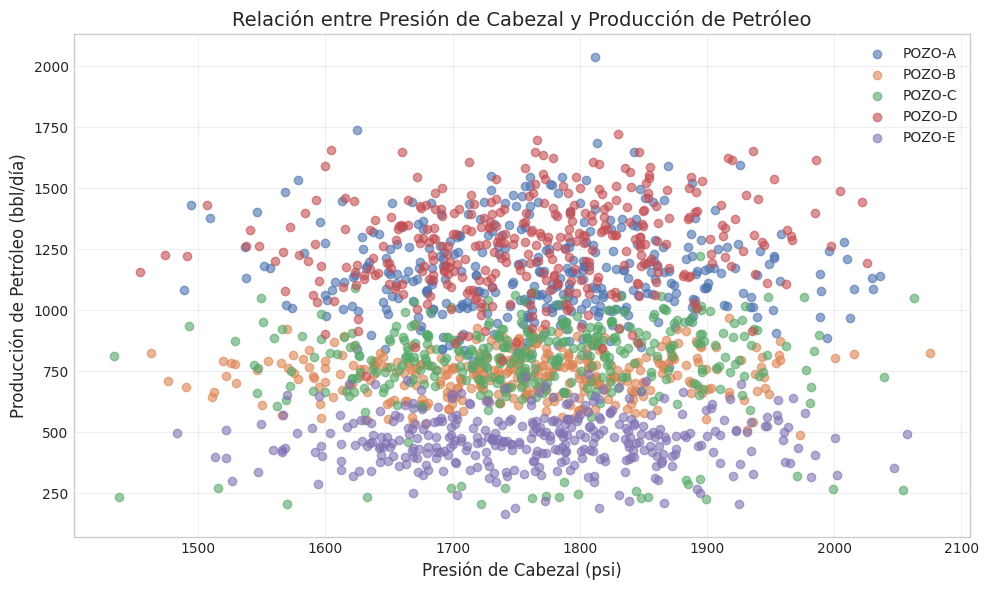

In [19]:
# Gráfico de dispersión: Relación entre presión de cabezal y producción
plt.figure(figsize=(10, 6))
for pozo in pozos:
    datos_pozo = df[df['pozo'] == pozo]
    plt.scatter(datos_pozo['presion_cabezal_psi'], datos_pozo['petroleo_bbl'], 
               alpha=0.6, label=pozo)

plt.title('Relación entre Presión de Cabezal y Producción de Petróleo', fontsize=14)
plt.xlabel('Presión de Cabezal (psi)', fontsize=12)
plt.ylabel('Producción de Petróleo (bbl/día)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

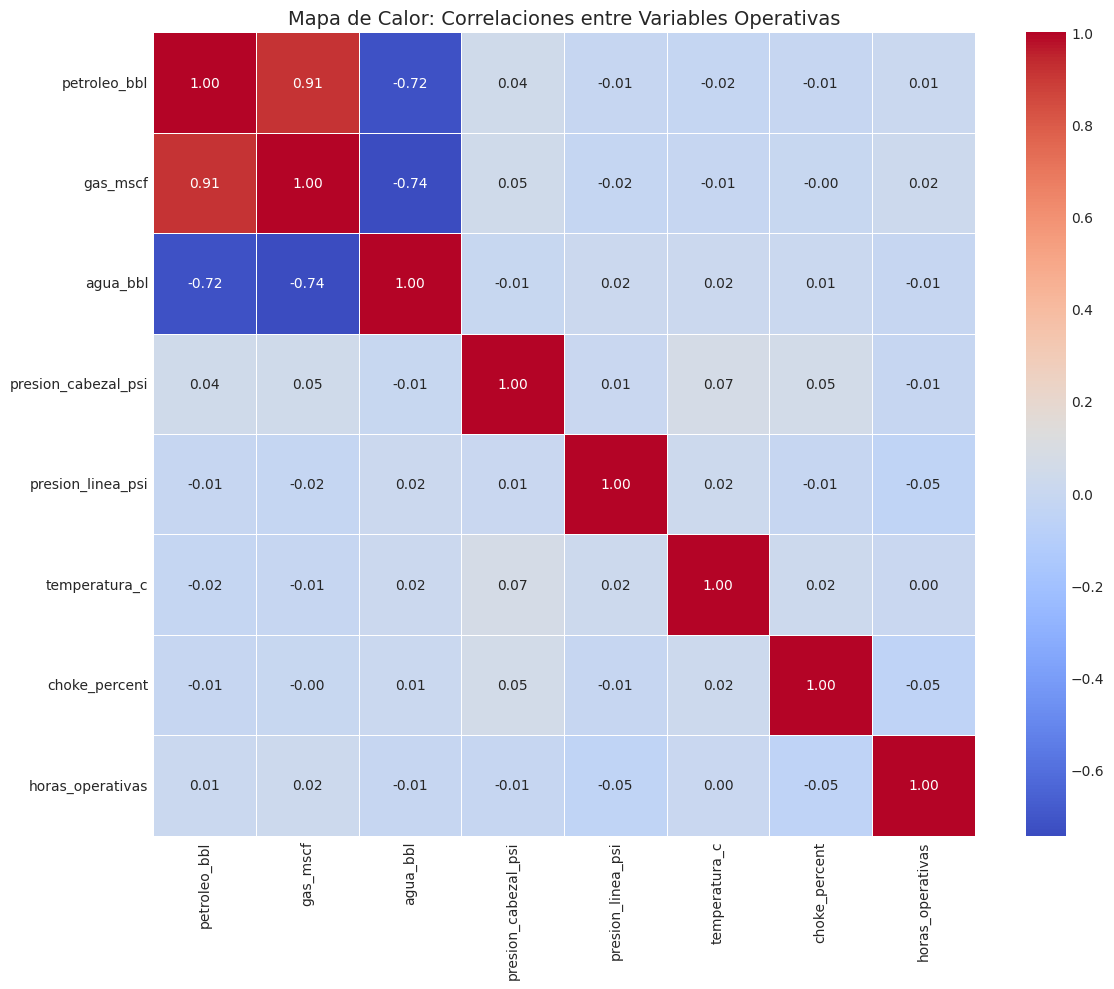

In [20]:
# Mapa de calor de correlaciones
plt.figure(figsize=(12, 10))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Mapa de Calor: Correlaciones entre Variables Operativas', fontsize=14)
plt.tight_layout()
plt.show()

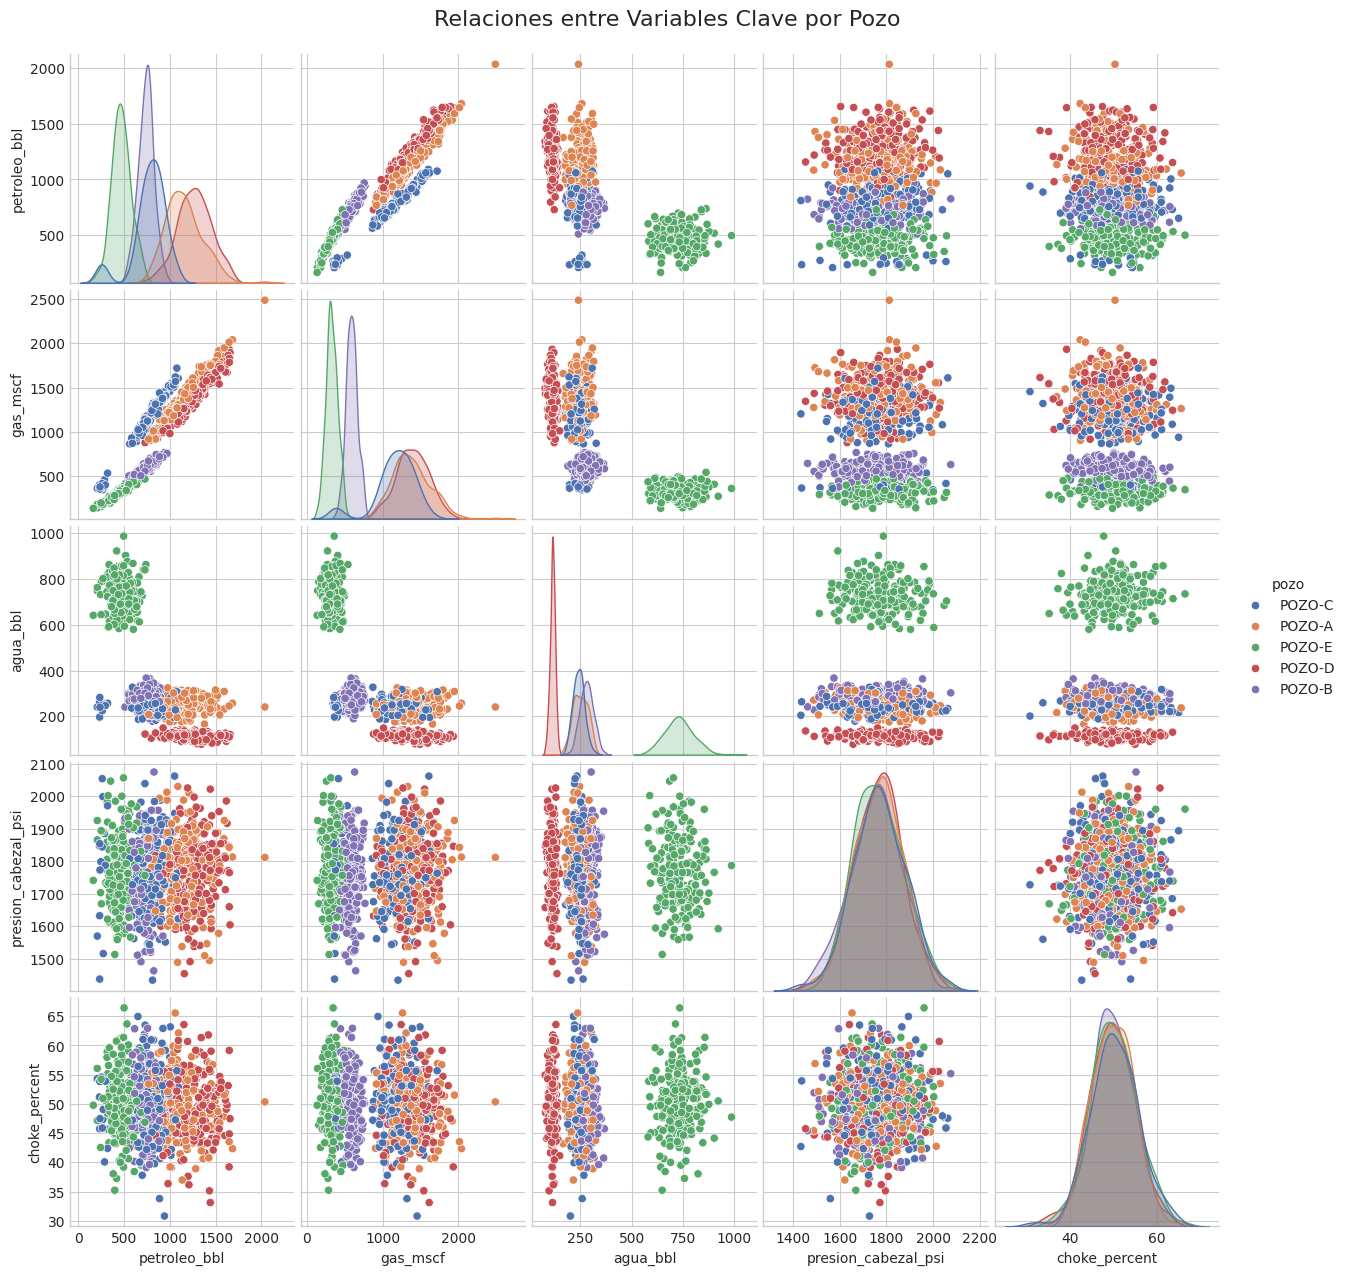

In [21]:
# Pairplot para analizar múltiples relaciones entre variables
variables_clave = ['petroleo_bbl', 'gas_mscf', 'agua_bbl', 
                  'presion_cabezal_psi', 'choke_percent']
sns.pairplot(df.sample(1000), vars=variables_clave, hue='pozo', height=2.5)
plt.suptitle('Relaciones entre Variables Clave por Pozo', y=1.02, fontsize=16)
plt.show()

## 5. Detección de Outliers y Eventos Anómalos

Los outliers pueden representar:
- Errores de medición o registro
- Eventos operativos reales (cierres, pruebas)
- Comportamientos anómalos que requieren atención

Identificarlos es crucial para análisis correctos y toma de decisiones.

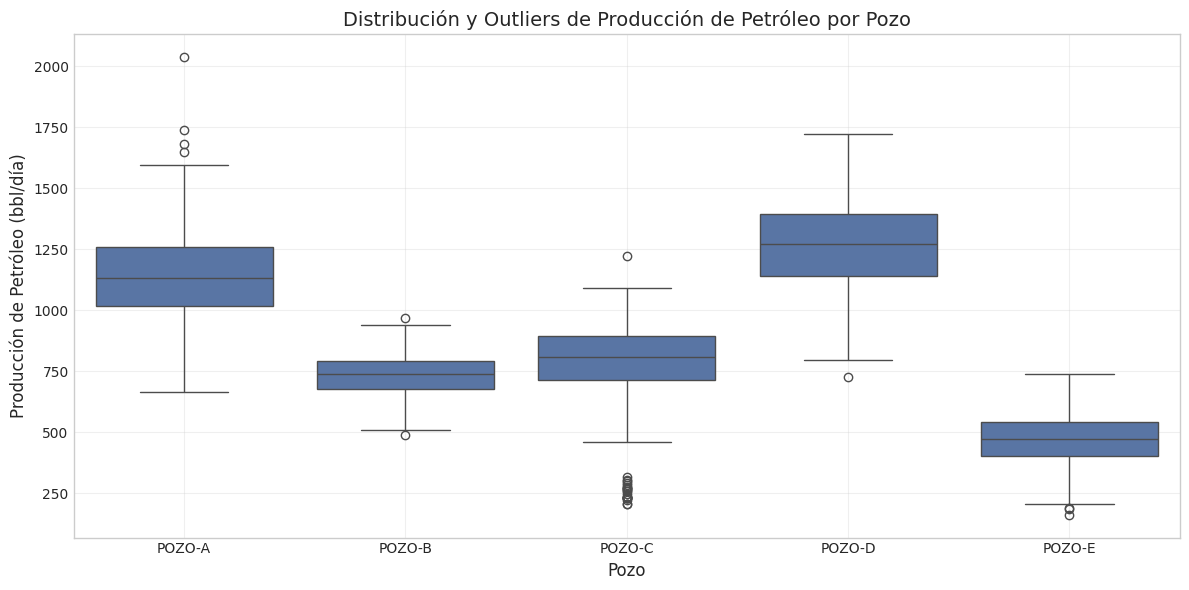

In [22]:
# Gráfico de boxplot para identificar outliers por pozo
plt.figure(figsize=(12, 6))
sns.boxplot(x='pozo', y='petroleo_bbl', data=df)
plt.title('Distribución y Outliers de Producción de Petróleo por Pozo', fontsize=14)
plt.xlabel('Pozo', fontsize=12)
plt.ylabel('Producción de Petróleo (bbl/día)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [24]:
# Método estadístico para detectar outliers (Z-score)
def detectar_outliers_zscore(df, columna, umbral=3):
    """Detecta outliers usando Z-score"""
    z_scores = abs((df[columna] - df[columna].mean()) / df[columna].std())
    return df[z_scores > umbral]

In [25]:
# Detectamos outliers por pozo usando Z-score
for pozo in pozos:
    datos_pozo = df[df['pozo'] == pozo]
    outliers = detectar_outliers_zscore(datos_pozo, 'petroleo_bbl', umbral=2.5)
    
    if not outliers.empty:
        print(f"\nOutliers detectados en {pozo} (producción de petróleo):")
        print(outliers[['fecha', 'petroleo_bbl', 'gas_mscf', 'agua_bbl']].head())


Outliers detectados en POZO-A (producción de petróleo):
         fecha  petroleo_bbl     gas_mscf    agua_bbl
209 2022-07-29   2037.002906  2485.873766  240.985364
220 2022-08-09   1739.625158  2099.961218  250.543701
234 2022-08-23   1683.227158  2038.737614  257.576263
252 2022-09-10   1647.032308  2012.727100  245.269915
262 2022-09-20    664.034810   790.552426  262.621727

Outliers detectados en POZO-B (producción de petróleo):
         fecha  petroleo_bbl    gas_mscf    agua_bbl
434 2022-03-11    968.729647  757.169375  290.893762
597 2022-08-21    488.926257  403.872824  225.253485
727 2022-12-29    508.718248  413.356792  240.684121

Outliers detectados en POZO-C (producción de petróleo):
         fecha  petroleo_bbl    gas_mscf    agua_bbl
780 2022-02-20    267.496996  347.437107  257.384393
781 2022-02-21    294.162695  401.106486  247.235600
782 2022-02-22    233.681713  337.268478  231.816435
783 2022-02-23    230.011751  401.674099  196.907037
784 2022-02-24    285.977007

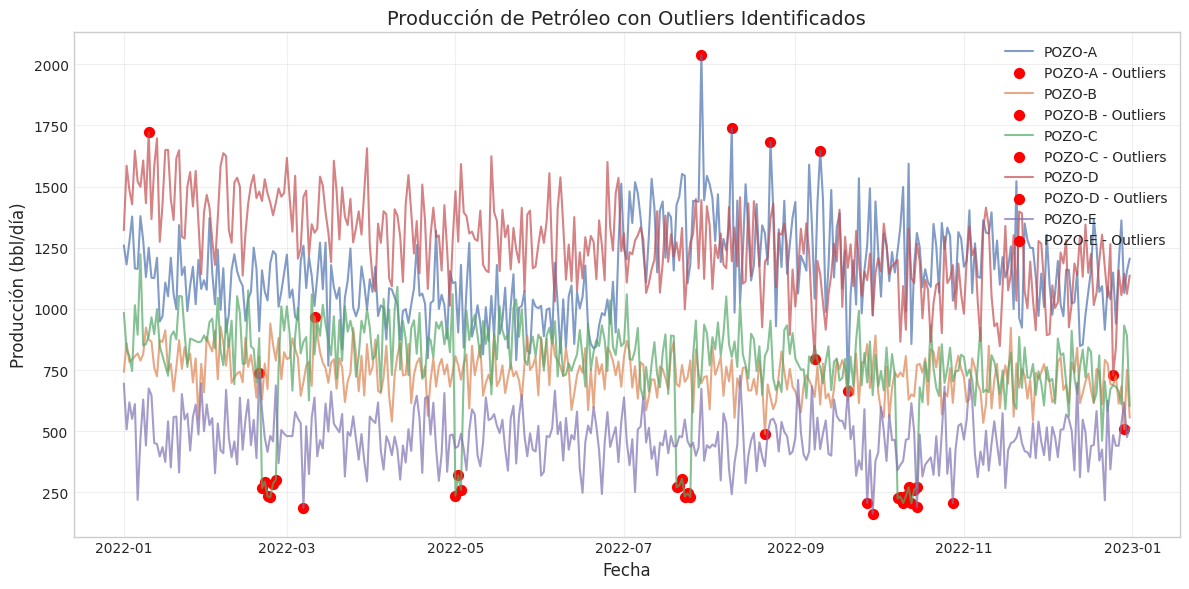

In [26]:
# Visualización de outliers en la serie temporal
plt.figure(figsize=(12, 6))
for pozo in pozos:
    datos_pozo = df[df['pozo'] == pozo]
    
    # Graficamos la serie normal
    plt.plot(datos_pozo['fecha'], datos_pozo['petroleo_bbl'], alpha=0.7, label=pozo)
    
    # Identificamos outliers
    outliers = detectar_outliers_zscore(datos_pozo, 'petroleo_bbl', umbral=2.5)
    
    # Marcamos los outliers
    if not outliers.empty:
        plt.scatter(outliers['fecha'], outliers['petroleo_bbl'], 
                   color='red', marker='o', s=50, label=f'{pozo} - Outliers')

plt.title('Producción de Petróleo con Outliers Identificados', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Producción (bbl/día)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## 6. Visualizaciones Avanzadas con Plotly (Interactivas)

Las visualizaciones interactivas proporcionan:
- Exploración más profunda de los datos
- Comunicación efectiva con stakeholders
- Capacidad para "contar historias" con los datos
- Análisis drill-down para identificar causas raíz

In [27]:
# Gráfico interactivo de producción por pozo
fig = px.line(df, x='fecha', y='petroleo_bbl', color='pozo',
             title='Producción de Petróleo por Pozo (Interactivo)',
             labels={'petroleo_bbl': 'Producción (bbl/día)',
                    'fecha': 'Fecha'})
fig.update_layout(xaxis_title='Fecha',
                 yaxis_title='Producción (bbl/día)',
                 legend_title='Pozo',
                 hovermode='closest')
fig.show()

In [28]:
# Dashboard interactivo con múltiples indicadores
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Producción de Petróleo', 'Corte de Agua', 
                   'Relación Gas-Petróleo', 'Producción Acumulada'),
    specs=[[{"type": "scatter"}, {"type": "scatter"}],
           [{"type": "scatter"}, {"type": "bar"}]]
)

# 1. Producción de petróleo
for pozo in pozos:
    datos_pozo = df[df['pozo'] == pozo]
    fig.add_trace(
        go.Scatter(x=datos_pozo['fecha'], y=datos_pozo['petroleo_bbl'],
                  name=pozo, mode='lines'),
        row=1, col=1
    )

# 2. Corte de agua
for pozo in pozos:
    datos_pozo = df[df['pozo'] == pozo]
    fig.add_trace(
        go.Scatter(x=datos_pozo['fecha'], y=datos_pozo['corte_agua'],
                  name=pozo, mode='lines', visible='legendonly'),
        row=1, col=2
    )

# 3. Relación gas-petróleo
for pozo in pozos:
    datos_pozo = df[df['pozo'] == pozo]
    fig.add_trace(
        go.Scatter(x=datos_pozo['fecha'], y=datos_pozo['gas_petroleo_ratio'],
                  name=pozo, mode='lines', visible='legendonly'),
        row=2, col=1
    )

# 4. Producción acumulada
fig.add_trace(
    go.Bar(x=produccion_acumulada.index, y=produccion_acumulada['petroleo_bbl'],
          name='Petróleo Acumulado'),
    row=2, col=2
)

# Actualizar layout
fig.update_layout(height=800, width=1000, title_text="Dashboard de Producción Petrolera",
                 legend_title='Pozo')
fig.show()

## 7. Ejercicios Prácticos para el Estudiante

Ahora es tu turno de aplicar lo aprendido con estos ejercicios prácticos.
Intenta resolverlos usando las técnicas y herramientas que hemos visto.

In [ ]:
# EJERCICIO 1: Identificar el pozo con mayor variabilidad en producción
# PISTA: Usa el coeficiente de variación (CV = desviación estándar / media)

# Tu código aquí


In [ ]:
# EJERCICIO 2: Crea un gráfico que muestre la evolución del corte de agua para cada pozo
# PISTA: Usa plt.figure() y un bucle para graficar cada pozo con diferente color

# Tu código aquí


In [ ]:
# EJERCICIO 3: Encuentra qué parámetro operativo tiene mayor correlación con la producción de petróleo
# PISTA: Usa la matriz de correlación que ya calculamos

# Tu código aquí


## 8. Conclusiones y Mejores Prácticas

Resumen de lo aprendido:

1. El análisis exploratorio de datos (EDA) es fundamental para entender el comportamiento
   de los pozos y detectar oportunidades de optimización.

2. Las visualizaciones efectivas transforman datos complejos en insights accionables,
   facilitando la comunicación con stakeholders.

3. Las técnicas estadísticas nos ayudan a cuantificar patrones, tendencias y relaciones
   entre variables operativas.

4. La detección de outliers y eventos anómalos permite identificar problemas operativos
   o errores en los datos.

5. Las herramientas interactivas como Plotly permiten análisis más profundos y
   comunicación efectiva de resultados.

Mejores prácticas:

- Siempre comienza con estadísticas descriptivas básicas
- Combina diferentes tipos de visualizaciones
- Considera el contexto operativo al interpretar los datos
- Documenta todos tus hallazgos con visualizaciones claras
- Utiliza herramientas interactivas para presentaciones a stakeholders

In [ ]:
print("¡Laboratorio completado con éxito!")